# Neural & Behavioral Modeling - Week 13 (Examples)
by Tren Huang (tren.huang@gmail.com)

In [1]:
%env KMP_DUPLICATE_LIB_OK=TRUE

env: KMP_DUPLICATE_LIB_OK=TRUE


In [2]:
%config IPCompleter.greedy=True 
# %matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np
import torch as t
from torch import nn
from torch import optim

In [3]:
# Check GPU status:
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 1.7.0+cu101
Device  0 : GeForce GTX 1050 Ti
Current: Device  0


In [3]:
# Supporting functions:

from datetime import datetime

def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total


def train(device, net, train_data, valid_data, num_epochs, optimizer, criterion):
    if t.cuda.is_available():
        net = net.cuda()
    prev_time = datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        net = net.train()
        #for im, label in train_data:
        for im, label in train_data:
            im=im.view(-1,im.shape[2],im.shape[3])
            im = im.to(device)  # (bs, h, w)
            label = label.to(device)
            # forward
            output = net(im)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.data.item()
            train_acc += get_acc(output, label)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()
            for im, label in valid_data:
                with t.no_grad():
                    im=im.view(-1,im.shape[2],im.shape[3])
                    im = im.to(device)
                    label = label.to(device)
                output = net(im)
                loss = criterion(output, label)
                valid_loss += loss.data.item()
                valid_acc += get_acc(output, label)
            epoch_str = (
                "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                % (epoch, train_loss / len(train_data),
                   train_acc / len(train_data), valid_loss / len(valid_data),
                   valid_acc / len(valid_data)))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str)

## 1 Recurrent Neural Networks

### 1.1 Simple Recurrent Network (SRN)
<img src="https://www.easy-tensorflow.com/images/NN/01.png" width=75%>

In [4]:
srn=nn.RNN(input_size=100, hidden_size=200)
print(srn.weight_ih_l0.shape)
print(srn.weight_hh_l0.shape)

torch.Size([200, 100])
torch.Size([200, 200])


In [5]:
x=t.randn(6, 5, 100) # (sequence length of inputs/outputs, batch size (# of sequences), feature dimensions of each element in a sequence)
h_0 = t.randn(1, 5, 200) # initial values of the hidden units

out, h_t = srn(x, h_0) # pass the input to the RNN
print(h_t.shape)
print(out.shape) # A squence of 6 elements

torch.Size([1, 5, 200])
torch.Size([6, 5, 200])


### 1.2 Long Short-Term Memory (LSTM)
<img src="https://discuss.pytorch.org/uploads/default/original/2X/e/e7496a33d835f085d800ee17c0ade05895a89551.png" width=50%>

In [6]:
lstm=nn.LSTM(input_size=100, hidden_size=200, num_layers=2) 
print(lstm.weight_ih_l0.shape, lstm.weight_ih_l1.shape) # 800 = 200 * 4 free parameters
print(lstm.weight_hh_l0.shape, lstm.weight_hh_l1.shape) # 800 = 200 * 4 free parameters

torch.Size([800, 100]) torch.Size([800, 200])
torch.Size([800, 200]) torch.Size([800, 200])


In [7]:
x=t.randn(6, 5, 100) # (seq, batch, feature)
out, (h, c)=lstm(x)
print(out.shape)
print(h.shape,c.shape)

torch.Size([6, 5, 200])
torch.Size([2, 5, 200]) torch.Size([2, 5, 200])


### 1.3 Gated Recurrent Unit (GRU)
<img src="https://miro.medium.com/max/2009/1*8nFrwolzTYtUWSaziiJGkg.png" width=50%>

In [8]:
gru=nn.GRU(input_size=100, hidden_size=200) 
print(gru.weight_ih_l0.shape) # 600 = 200 * 3 free parameters
print(gru.weight_hh_l0.shape) # 600 = 200 * 3 free parameters

torch.Size([600, 100])
torch.Size([600, 200])


In [9]:
x=t.randn(6, 5, 100) # (sequence, batch, feature)
h_0 = t.randn(1, 5, 200) # initial values of the hidden units

out, h_t = gru(x, h_0) # pass the input to the RNN
print(h_t.shape)
print(out.shape) # A squence of 6 elements

torch.Size([1, 5, 200])
torch.Size([6, 5, 200])


## 2. RNN v.s. CNN

### 2.1 RNN on images

#### 2.1.0 The MINST dataset

In [10]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],std=[0.5])])

train_set = datasets.MNIST(root = "./data",
                               transform = transform,
                               train = True,
                               download = True)

train_data = t.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)


test_set = datasets.MNIST(root = "./data",
                              transform = transform,
                              train = False)

test_data = t.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

#### 2.1.1 The RNN model

In [11]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size = 28,
                                hidden_size = 128,
                                num_layers = 1,
                                batch_first = True)
        
        self.classifier = nn.Linear(128,10)
        
    def forward(self, input):
        output,_ = self.rnn(input, None)
        output = self.classifier(output[:,-1,:])
        return output

In [98]:
srn = RNN()
optimizer = optim.Adam(srn.parameters())
criterion = nn.CrossEntropyLoss()
train(device, srn, train_data, test_data, 3, optimizer, criterion)

Epoch 0. Train Loss: 0.870776, Train Acc: 0.702392, Valid Loss: 0.444024, Valid Acc: 0.866043, Time 00:00:08
Epoch 1. Train Loss: 0.332477, Train Acc: 0.903535, Valid Loss: 0.269307, Valid Acc: 0.921975, Time 00:00:09
Epoch 2. Train Loss: 0.254030, Train Acc: 0.927955, Valid Loss: 0.223551, Valid Acc: 0.939291, Time 00:00:08


### 2.2 RNN on time series

#### 2.2.0 The data

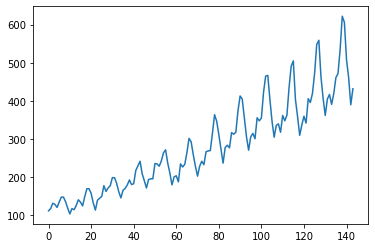

In [4]:
import pandas as pd
ts = pd.read_csv('data.csv', usecols=[1]).dropna().values.astype('float32')
plot(ts); 

144


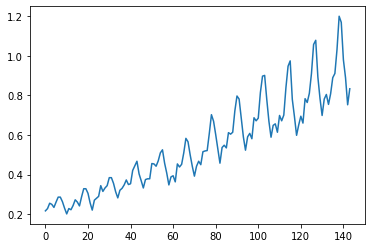

In [5]:
# Normalize:
max_value = np.max(ts)
min_value = np.min(ts)
scalar = max_value - min_value
ts = list(map(lambda x: x / scalar, ts))
print(len(ts))
plot(ts); 

In [16]:
# Prepare windowed data for our RNN model(s):
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)
dataset = ts
data_X, data_Y = create_dataset(dataset)

print(data_X[0],data_Y[0]) # (Xt-2, Xt-1) -> Xt

[[0.21621622]
 [0.22779922]] [0.25482625]


In [17]:
# Train-Test split:
train_size = int(len(data_X) * 0.7) # 70% for training
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

print(train_X.shape,train_Y.shape)

(99, 2, 1) (99, 1)


In [18]:
# Reshape the data into (seq, batch, featue)
train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

print(train_x.shape,train_y.shape)

torch.Size([99, 1, 2]) torch.Size([99, 1, 1])


#### 2.2.1 The LSTM model

In [19]:
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # regression
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # flatten
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [20]:
net = lstm_reg(input_size=2, hidden_size=10)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)

In [24]:
# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # print loss every 100 epochs
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
    

0.0035213492810726166
0.001575483474880457
0.000587979971896857
0.0003806956810876727
0.00024854650837369263
0.00018113924306817353
0.00015908760542515665
0.0001459198974771425
0.00013717488036490977
0.00018231144349556416


In [6]:
# Testing on the whole series (70% trained + 30% untrained):
net = net.eval() 
data_X2 = data_X.reshape(-1, 1, 2)
data_X3 = t.from_numpy(data_X2)
pred_test1 = net(data_X3) 
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
print(pred_test1.shape, pred_test2.shape, len(dataset))

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(dataset[2:], 'b', label='real');

NameError: name 'net' is not defined

### 2.3 CNN on time series


#### 2.3.0 The data


In [368]:
print(data_X.shape, data_Y.shape) # (seq, feature, batch)

(142, 2, 1) (142, 1)


In [369]:
# Train-Test split:
data_X4 = np.swapaxes(data_X,1,2) # should be (batch, channel, input)
L=data_X4.shape[0]
train_size = int(L * 0.7) # 70% for training
test_size = L - train_size
train_X = data_X4[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X4[train_size:]
test_Y = data_Y[train_size:]

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

print(train_x.shape,train_y.shape) # (batch,input,feature)

torch.Size([99, 1, 2]) torch.Size([99, 1])


#### 2.3.1 The model
<img src="https://i.stack.imgur.com/QVASQ.png" width=75%>

In [370]:
class cnn_reg(nn.Module):
    def __init__(self, in_channels, hidden_size, output_size, kernel_size):
        super(cnn_reg, self).__init__()
        
        self.conv = nn.Conv1d(in_channels=in_channels, out_channels=hidden_size, kernel_size=kernel_size) # in_channels=features

        self.reg = nn.Linear(hidden_size, output_size) # regression
        
    def forward(self, x):
        x = self.conv(x) # (batch, channel, input)
        x=x.view(x.size()[0], -1) # flatten
        x = self.reg(x)
        return x

In [377]:
net = cnn_reg(in_channels=1, hidden_size=10, output_size=1, kernel_size=2)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)

In [378]:
# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # print loss every 100 epochs
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.data[0]))

/raid/opt/hpc/anaconda/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()


Epoch: 100, Loss: 0.00590
Epoch: 200, Loss: 0.00346
Epoch: 300, Loss: 0.00298
Epoch: 400, Loss: 0.00259
Epoch: 500, Loss: 0.00231
Epoch: 600, Loss: 0.00211
Epoch: 700, Loss: 0.00200
Epoch: 800, Loss: 0.00194
Epoch: 900, Loss: 0.00191
Epoch: 1000, Loss: 0.00190


torch.Size([142, 1]) (142,) 144


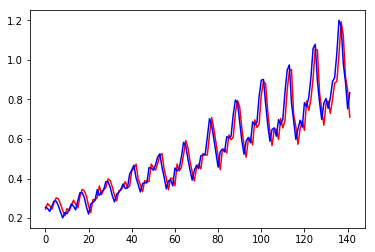

In [379]:
# Testing on the whole series (70% trained + 30% untrained):
net = net.eval() 
pred_test1 = net(t.from_numpy(data_X4))
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
print(pred_test1.shape, pred_test2.shape, len(dataset))

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(dataset[2:], 'b', label='real');

## 3 Character RNN as a Language Model

### 3.0 Supporting Functions

In [ ]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = t.multinomial(output_dist, 1)[0]
        
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

### 3.1 The data

In [ ]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('alice_in_wonderland.txt').read())
file_len = len(file)
print('file_len =', file_len)

In [ ]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

In [ ]:
# Turn string into list of longs
def char_tensor(string):
    tensor = t.zeros(len(string)).long().unsqueeze(1)
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

print(char_tensor('abcDEF'))

In [ ]:
# Prepare training data using number coding:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

print(random_training_set())
#print(*random_training_set())

### 3.2 The model

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return t.zeros(self.n_layers, 1, self.hidden_size)

In [ ]:
n_epochs = 20000
print_every = 1000
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = t.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = [0]
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Al', 500), '\n')

 48s (1000 5%) 1.7217]
Aly just little repeactrate been of down were is dow of you she loik tmate, and to said tees would the
    I down eyes, 'I' me aclious not in make, and but wer tow you was t5able in would withould it dore its could, 'Comely, I deardned I prom why soll way Arches the Mouse.

'Cat
had don't if you deat inded the was cour did the Mouse, 'Reame was, Alice repirto the March I hand
then were said the the rethen heard, and her har welones wore litterable the he door had not intating out on a little she h 

 54s (2000 10%) 1.1834]
All interner shole which the poway sueblige the prigas, with the pair little can in, with any
that she fither of in an it uppont the sele an thent, and thing
his her with a getting haves.

'I neeze, who hold looking anied the other way with a person of for the twink an the shough time smationd--'

'So she were the pore anyrone intance!'

'Choly who scairly, and had be no lay to be nouse had thought of the she work
she! the cried the othented yo